# ASTR 596: FDS Homework 7: Selection Effects as Hierarchical Models

## Alex Gagliano
## Due 05/24/2020 (Or sometime around there) 

## <font color='red'> When you first look at the size of the notebook, it'll be overwhelming. There is a lot of text largely to help explain things step by step. It's just really broken up into many small steps. Answers for Q1-7 are 1--2 lines each. and Q8 is 10. The PGM will take longer if you use `daft` than anything else.
</font>


#### So far, we've been making inferences from sample assuming that the sample we're working with is representative of the underlying population.

#### This is a fantastically bad assumption, because it's almost always wrong. 

#### Every astronomical dataset we've used in this class exhibits *selection effects* - you saw fewer Cepheids in more distant galaxy, you saw fewer stars in SDSS in regions with high extinction, you miss variable stars with periods around 1 day because you sample the sky with the same timescale imposed by the Earth's rotation, you don't see meteors like Chelyabinsk coming in from the direction of the Sun because the background is too high to detect such faint sources...

<img src="selection_effect.png">

#### If you imagine a forward model for the data, then there's one extra step now that impacts what you get in your sample, and so the inverse problem - learning about the population from the sample - is potentially biased by the failure to account for selection effects.

#### Since selection effects enter via detection criteria, we have to incorporate these into the model.

#### You're going to build a forward model for a survey incorporating selection effects.

<hr>

We'll simulate survey observations based on a simplified model for photon-counting aperture photometry.

If our model telescope has a collecting area $A$ and integrates for a time $T$, the total exposure $\epsilon = A\cdot T$ toward a targeted source. 

The expected number of source photons detected from a source with photon number flux $F$ is thus $\epsilon \cdot F$.

Of course backgrounds and instrumental contributions to the detected photons. Sky backgrounds and integrating instrumental backgrounds (such as dark current for a CCD) can be modeled by adding a background rate, $B$, to the flux.  We'll also consider additive contamination with a fixed expected number of counts, $C$ (such as from effects like readout or amplifier noise).  

The total expected number of counts from a source is:
\begin{align}
\mu(F) & = \epsilon F + \epsilon B + C \\
 & = \epsilon F + \nu
\end{align}

with $\nu \equiv \epsilon B + C$ denoting the expected number of non-source photons. We'll assume that all the exposures are the same.

In this setup, the data from the observation of a source comprise a single integer, the observed number of counts in aperture, $n$ (we'll use $n_i$ when we consider multiple sources, with $i$ being the source index).

<hr>

<font color='blue'>

#### Q1. To *simulate* observations, we need to specify a *sampling distribution* telling us how to generate data when the *source* properties are specified. We've encountered this distribution multiple times already (remember you don't get a non-integer number of photons). Write down an expression for the sampling distribution for the number of photons $n$ given the source flux $F$

</font>

We're considering a counting experiment here, so the sampling distribution can be none other than the Poisson. Here our mean is going to be the model counts, which is determined by the source flux and the exposure: 

$$ P(n|F) = \frac{(\epsilon F)^n e^{-\epsilon F}}{n!} $$

We implement this below.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

def sample(F):
    eps = 320 #from later parts
    return np.random.poisson(lam=eps*F)

<hr>
<font color='blue'>
    
#### Q2. Once we have simulated data, we need the *likelihood function* $\ell(F)$ in order to estimate the source flux $F$ given the detected photons $n$ except now we have to take into account the noise model. Write down an expression for the likelihood function for the source Flux, given the number of photons $n$.
</font>

We now have to consider both the counts from the source itself and from the background noise in the likelihood. The likelihood for a single source with flux $F$ is just the probability mass function (pmf) of a poisson distribution, which is the exact same thing as we wrote above, but with a new mean:

$$L(n) = \frac{(\epsilon F + \nu)^n e^{-(\epsilon F + \nu)}}{n!}$$

We'll have to sample the noise and wrap it into our total counts $n$ later on. Coding this up:

In [2]:
def like(F, n):
    eps = 320 #from later parts
    B = 1 #background flux
    C = 1 #counts, constant
    FB = np.random.poisson(lam=B)
    nu = eps*FB+C
    n_model = eps*F + nu
    return poisson.pmf(n, n_model)

Remember that the likelihood is *not normalized over flux*  - it isn't meaningful to integrate it over $F$ without multiplication by a prior (such as a candidate population distribution for $F$).  

<hr> 
<font color='blue'>

#### Q3. The $n$-dependent MLE estimate of the source flux, $\hat{F}(n)$, can be found by setting $\ell'(\hat{F}) = 0$. Write down the maximum likelihood estimate of the flux.

</font>

Now we're getting good at writing it: the pmf takes the form $$ L(F) = P(n|F) = \frac{\lambda^n e^{-\lambda} }{n!} =  \frac{(\epsilon \hat{F} + \nu)^n e^{-\epsilon \hat{F} - \nu} }{n!}$$ 

Where $n$ is the number of photons collected. Taking the log of the likelihood (easier to derivate), we get 

$$
\ell(\hat{F}) = n ln(\epsilon \hat{F} + \nu) - \epsilon \hat{F}  - \nu - ln(n!)
$$

Then, taking its derivative with respect to $F$ and setting it equal to 0 yields: 

$$
\frac{n}{\epsilon \hat{F} + \nu}\epsilon - \epsilon = 0
$$

$$
\implies n = \epsilon \hat{F} + \nu
$$

$$ \implies \hat{F} = \frac{n - \nu}{\epsilon} $$

Not entirely enlightening - if our model for the counts is $n = \epsilon F + \nu$, then our best estimate for the flux can be found from the same equation.

Coding this up:

In [3]:
def muMLE(n):
    eps = 320 #from later parts
    B = 1 #background flux
    C = 1 #counts, constant
    FB = np.random.poisson(lam=B)
    nu = eps*FB+C
    mean = (n-nu)/eps
    return mean

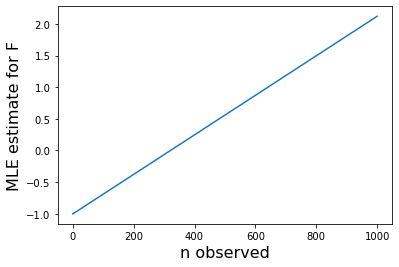

In [4]:
n_vals = np.logspace(-3,3)
plt.plot(n_vals, muMLE(n_vals));
plt.xlabel("n observed",fontsize=16);
plt.ylabel("MLE estimate for F",fontsize=16);

Makes sense, makes sense.

We'll need the negative log likelihood for the MCMC below, but we don't worry about that yet. 

<hr>
<font color='blue'>

#### Q4. The $n$-dependent standard deviation of the Gaussian can be found by computing a second derivative of the likelihood and matching it to the second derivative of the Gaussian.
</font>

This time, we'll take the second derivative. We start with the first derivative from above:  
$$
\frac{\partial \ell}{\partial \hat{F}} = \frac{n}{\epsilon \hat{F} + \nu}\epsilon - \epsilon
$$

$$
\frac{\partial \ell}{\partial \hat{F}} = \frac{n}{\hat{F} + \frac{\nu}{\epsilon} }- \epsilon
$$

$$
\frac{\partial^2 \ell}{\partial \hat{F}^2} = -\frac{n}{(\hat{F} + \frac{\nu}{\epsilon})^2}
$$

If we pretend that this distribution is in fact a Gaussian centered upon $\hat{\epsilon F} + \nu$. For large numbers this shouldn't be a bad estimate. 
Matching this to the second derivative of the Gaussian, which we've found from wikipedia: 

$$
\frac{\partial^2 G}{\partial \hat{F}^2} = -\frac{1}{\sigma^2} G(\hat{F})
$$

$$
\frac{-1}{\sigma^2} = \frac{-n}{(\hat{F} + \nu/\epsilon)^2}
$$

$$
\implies \sigma^2 = \frac{(\hat{F} + \nu/\epsilon)^2}{n}
$$
Plugging in our best estimate for the mean flux $\hat{F} = \frac{n - \nu}{\epsilon}$, we get

$$\sigma^2 = \frac{(\frac{n - \nu + \nu}{\epsilon})^2}{n}$$

$$ \sigma^2 = \frac{\frac{n^2}{\epsilon^2}}{n}$$

$$
\sigma = \frac{\sqrt{n}}{\epsilon}
$$

Nice! It makes intuitive sense that the uncertainty in the flux goes as $\sqrt{n}$ (it's counting statistics, after all) and that the uncertainty should go down even further with greater collecting area and/or exposure time. 

<hr>

<img src="selection_effect_so_far.png">

OK, if we're good up to here, we've specified how to go from observables ($F$) to measurements ($n$) i.e. we know given a source with flux, $F$ we use the sampling distribution to get an estimate of the number of photons $n$ 

We now have to specify a **population distribution** for sources - what's the distribution of $F$ itself across sources.

We'll use a version of a power-law distribution.

Let $g(F; \theta)$ denote the flux distribution probability density function $PDF$, with parameters $\theta$ (that we will sometimes suppress for notational brevity).  


It's annoying to have to think about behavior in terms of the actual flux in ergs/cm^2/sec so instead let us convert to a dimensionless flux. If we choose a *fiducial flux*, $F_0$ - maybe a physically interesting scale (e.g., a solar luminosity at 10 pc), or simply a convenient unit (e.g., $10^{-7}$ photons/cm$^2$/s), then we can switch to log space using:

$$
x = \log\left(\frac{F}{F_0}\right), \qquad\qquad
y = \log\left(\frac{g(F)}{g(F_0)}\right).
$$

A power law is a straight line in $(x,y)$ space; its slope is the *power law index* (sometimes the negative slope is called the index).  

That is, if

$$
g(F) = C\left(\frac{F}{F_0}\right)^\alpha,
$$

with $C$ a normalization constant, then 

$$
\frac{dy}{dx} = \alpha.
$$


Let's generalize this a bit, seeking to make the power law index vary with flux.  Let's pick $F_0$ to be the flux at which the slope is $\alpha$, and let the slope change linearly away from there. This leads to
$$
\frac{dy}{dx} = \alpha + \beta x.
$$

This corresponds to power law behavior with index $\alpha$ at $\xi$, but with the index linearly "rolling" with respect to log-flux.


What does such a choice for the transformed log flux $x$ imply for the real flux $F$ distribution? First note that although $g(F)$ is a PDF for $F$, it's not the case that $y(x)$ is a PDF for $x$.  The nonlinear change of variables from $F$ to $x$ means that the PDF for $x$, $h(x)$, must be computed using a Jacobian:

\begin{align}
h(x) 
  &= g(F(x))\left|\frac{dF}{dx}\right| \\
  &= g[F_0 e^x]\, F_0 e^x.
\end{align}

Conversely, if we specify the PDF for the log-flux, we can compute $g(F)$ via
\begin{align}
g(F) 
  &= h(x(F))\left|\frac{dx}{dF}\right| \\
  &= \frac{1}{F} h[\log(F/F_0)].
\end{align}
(Check the dimensions again!)

If $h(x)$ is a normal distribution (for $x$, the log-flux), with mean $\mu$ and standard deviation $\sigma$ (both dimensionless). We then have
$$
h(x) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left[-\frac{(x - \mu)^2}{2\sigma^2}\right].
$$


This corresponds to a $g(F)$ given by the Jacobian rule above:
$$
g(F) = \frac{1}{F}\cdot\frac{1}{\sigma\sqrt{2\pi}} \exp\left[-\frac{(\log(F/F_0) - \mu)^2}{2\sigma^2}\right].
$$
This is a *log-normal distribution* for the flux.


Now compute its slope in $(x,y)$ log space.  The result is
$$
\frac{dy}{dx} = \left(\frac{\mu}{\sigma^2} - 1\right) - \frac{x}{\sigma^2}.
$$

Comparing with our linearly-rolling law, above, we see that a log-normal distribution corresponds to a rolling power law with index $\alpha = \mu/\sigma^2 -1$ at $F=F_0$, and with rate of change of slope $\beta = -1/\sigma^2$.  Note that $\beta$ must be negative.

So a log-normal flux distribution will look like a power law with index $\alpha = \mu/\sigma^2-1$ if $\beta$ is small (i.e., $\sigma$ is large). Estimating $\beta$ measures departure from pure power law behavior.


## Phew.

<font color='blue'>
    
#### Q5. Given alpha and beta, write code that implements a log-normal flux PDF

#### Scipy of course has this, **but see the note here bout SciPy's funky scale param**:
    
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
  
##### Plot the PDF as a function of the dimensionless flux $F/F_0$ with a log-log scale
    
</font>

Let's start by finding $\mu$ and $\sigma$ in terms of $\alpha$ and $\beta$:

$$
\alpha = \frac{\mu}{\sigma^2} - 1
$$
$$
\mu = (\alpha + 1) \sigma^2
$$
$$
\beta = \frac{-1}{\sigma^2}
$$
$$
\sigma = \sqrt{-\frac{1}{\beta}}
$$
$$
\mu = (\alpha + 1) \left(\sqrt{-\frac{1}{\beta}} \right)^2
$$

$$
\mu = -\frac{\alpha + 1}{\beta}
$$


Then, our lognormal distribution from above becomes:
$$
g(F) = \frac{1}{F\sqrt{\frac{-2\pi}{\beta}}} \mathrm{exp}\left[\frac{\left(log(F/F_0) + \frac{\alpha + 1}{\beta}\right)^2}{2(1/\beta)} \right]
$$

$$
g(F) = \frac{1}{F\sqrt{\frac{-2\pi}{\beta}}} \mathrm{exp} \left[\frac{\beta}{2}\left(\mathrm{log}(F/F_0) + \frac{\alpha + 1}{\beta}\right)^2 \right]
$$

We code this up here:

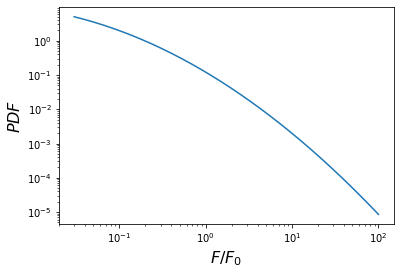

In [5]:
alpha, beta = -1.5, -0.25  # fiducial index, roll rate
f_vals = np.logspace(np.log10(0.03), np.log10(100), 250)
f0 = 1. #arbitrary normalization
def g(alpha, beta, f):
    pdf = 1/f * 1/np.sqrt(-2*np.pi/beta) * np.exp(beta/2 * (np.log(f/f0) + (alpha + 1)/beta)**2)
    return pdf

plt.loglog(f_vals/f0, g(alpha, beta,f_vals))
plt.xlabel(r"$F/F_0$",fontsize=16);
plt.ylabel(r"$PDF$",fontsize=16);

Does this look reasonable? Let's see what happens as $\beta$ gets close to 0:

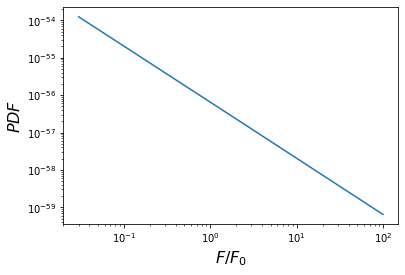

In [6]:
plt.loglog(f_vals/f0, g(alpha, -0.001,f_vals))
plt.xlabel(r"$F/F_0$",fontsize=16);
plt.ylabel(r"$PDF$",fontsize=16);

Nearly flat in log-log space! Great.

<hr> 

Finally, the presence of backgrounds means that photons will be counted in an aperture even in the absence of a source.  

To guard against false detections, we introduce a detection threshold, $n_{\rm threshold}$, requiring that $n > n_{\rm th}$ for a candidate source to enter the survey catalog.  For simplicity, we'll choose $n_{\rm threshold}$ large enough that the probability for a false detection is negligible, so the catalog is "pure" with high probability.

The cost of purity is missing sources - we reject dim sources that happen to produce counts below threshold - our catalog is **incomplete**.

To account for this, we need the *detection efficiency*, $\eta(F)$, the probability for detecting a source of flux $F$.  This is just the probability of getting $n > n_{\rm th}$ when $F$ is given:

\begin{align}
\eta(F) 
  &= p(n > n_{\rm th}|F) \\
  &= \sum_{i=n_{\rm th}+1}^\infty p(n|F)
\end{align}

<font color='blue'>
    
#### Q6. To write this as an expression for the detection efficiency $\eta(F)$, consider the [Incomplete gamma function - Wikipedia](https://en.wikipedia.org/wiki/Incomplete_gamma_function). 

#### The combination $P(s,x) \equiv \gamma(s,x)/\Gamma(s)$ (with $\Gamma(s)$ the gamma function) is called the regularized lower incomplete gamma function; SciPy provides this as `scipy.special.gammainc(s,x)`.  When $s$ is an integer, $\Gamma(s) = (s-1)!$

</font>

Just as you've noted above, we'll use the lower incomplete gamma function for the detection efficiency, where $n_{th}$ is our threshold photon count:

$$ \eta(n_{th} + 1, F) = \frac{1}{n_{th}!} \int_0^{\epsilon F + \nu} t^{n_{th}} e^{-t} dt $$

Implementing this: 

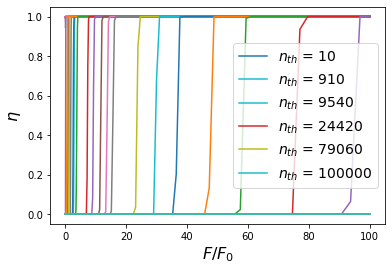

In [7]:
from scipy.special import gammainc 
def eta(nth, F):
    eps = 320 #from later parts
    B = 1 #background flux
    C = 1 #counts, constant
    FB = np.random.poisson(lam=B)
    nu = eps*FB+C
    mu = F*eps + nu
    return gammainc(nth+1, mu)
    
nth = np.logspace(0, 5, num=50)

for n in nth:
    if int(n)%10 == 0:
        plt.plot(f_vals/f0, eta(n, f_vals), label=r'$n_{th}$ = %i'%n)
    else:
        plt.plot(f_vals/f0, eta(n, f_vals))

plt.xlabel(r"$F/F_0$",fontsize=16);
plt.legend(fontsize=14)
plt.ylabel(r"$\eta$",fontsize=16);

Okay, so we didn't need to plot that many, but we can see that the efficiency increases with increasing flux (as expected), but as we increase our threshold $n_{th}$ we need a higher flux for detection.

# Parameter choices

For our simulation we must specify the survey parameters governing measurement and detection, and a choice of parameters for the underlying "true" flux distribution.

First let's specify the detection threshold.  

A convenient and common specification is to choose $n_{\rm th}$ so that $\hat{F}(n_{\rm th})$ is some fixed multiple, $k$, of the uncertainty, $\sigma_F(n_{\rm th})$ (i.e., we require detections to be above "$k$ sigma").  This corresponds to solving
$$
\hat{F}(n_{\rm th}) = k\, \sigma_F(n_{\rm th})
$$
for $n_{\rm th}$.  

This gives an equation involving $n_{\rm th}$ and $\sqrt{n_{\rm th}}$, i.e., a quadratic equation for $\sqrt{n_{\rm th}}$.  The solution is
$$
n_{\rm th} = k^2\, \left(\frac{1 + \sqrt{1 + 4\nu/k^2}}{2}\right)^2.
$$
Note that if the expected background contribution $\nu=0$, we have $n_{\rm th} = k^2$, a result we would have guessed from the root-$n$ rule.

#### As a starting point, let's use a 4-$\sigma$ detection criterion, with $\nu = 9.373$, for which
$$
\large
n_{\rm th} = 2 k^2 = 32.
$$

Now we must specify the effective area and integration time, or equivalently, the exposure, $\epsilon$.  Since only the product, $\epsilon F$, enters the calculations, for any choice of flux scale, we can find an exposure that will produce any desired photon count expectation value.  

#### We'll choose the exposure so that the expected counts will equal $n_{\rm th}$ for a flux $F = 0.1 F_0$; that is, we set
$$
\large 
0.1 \epsilon F_0 + \nu = n_{\rm th},
$$

which gives 

#### $$\epsilon = 320/F_0$$  

We can set $F_0$ to a specific value; alternatively we can work in terms of a dimensionless flux, $f = F/F_0$. 

#### For the population model, let's set the index at $F_0$ to have rolled off of the canonical homogenous population value, $\alpha = -5/2$, by one, i.e., $\alpha = -1.5$.  As a starting point we'll consider $\beta = -0.25$.  When the flux reaches $\approx 50\times F_0$, the log-slope reaches the $-5/2$ value.


#### THAT'S EVERYTHING SPECIFIED IN THE FIGURE

<hr> 

<font color='blue'>

#### Q7. OK, so now apply the detection efficiency to the population distribution, and show the original distribution vs the detected population that is subject to selection effects (aka "thinned"). As you've hopefully realized from the Q5., it'll pay to work in log-log axes. 
    
</font>

Simply multiplying the two distributions together: 

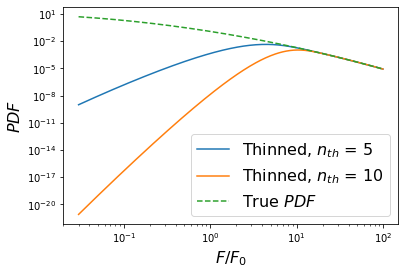

In [8]:
nth = [5,10]
eps = 1
for n in nth:
    plt.loglog(f_vals, eps*gammainc(n/eps, f_vals)*g(alpha, beta, f_vals), label=r"Thinned, $n_{th}$ = %i"%n);
plt.loglog(f_vals, eps*g(alpha, beta, f_vals), linestyle='--', label=r"True $PDF$");
plt.legend(fontsize=16);
plt.xlabel(r"$F/F_0$", fontsize=16)
plt.ylabel(r"$PDF$",fontsize=16);

<font color='blue'>
    
#### Q8. Monte-Carlo time! 

#### Simulate a catalog with 10,000 **detections**. Because of selection effects there'd better be more underlying sources than the ones you detected. 

* Draw the latent (true) fluxes from the **population distribution** - keep a track of these true fluxes
* The total expected number of photons $\mu(F) = \epsilon F + \nu$ again - keep a track of these true counts
* Using your answer for Q1 i.e. the **sampling distribution** to simulate a signal
* Using your answer for Q3 i.e. the MLE estimate of the flux (which depends on what you did in Q2), estimate the flux of your signal - keep a track of these estimated fluxes
* Just because a process generated a signal does not mean that you detected that signal. Apply the detection threshold n_threshold to the signals you simulated
* Keep generating until you 10,000 detections

Finally, plot the true vs estimated fluxes for all signals you simulated in red, and the signals you actually detected in blue.

Histogram the estimated flux for all signals and detected signals and compare to your answer for Q7. You'll need to use log-log again.

</font>

Okay, here goes something:*

*I changed the colors up a bit to make it more aesthetically pleasing.

In [51]:
import warnings
warnings.filterwarnings('ignore')

#for the noise
from scipy.optimize import minimize
from scipy.special import factorial
B = 1 #some background flux
C = 1 #counts, constant

# These will hold the data, i.e., counts.
all_cts, detected_cts = [], []

# Keep track of true fluxes.
true_flux, detected_true_flux = [], []

# These will hold dimensionless flux estimates.
est_flux, detected_est_flux = [], []

# we need to code up the log-likelihood here: 
def neg_log_like(mu, n):
    ll = -(n * np.log(mu) - mu - np.log(float(factorial(n))))
    return ll

#using the same alpha and beta above:
f_vals = np.logspace(np.log10(0.03), np.log10(100), 1000)
true_pop = g(alpha, beta,f_vals)
nth = 10 #pick at random?
detected = 0
nll = lambda *args: neg_log_like(*args)
all = 0

while detected < 1.e4:
    all += 1
    F = np.random.choice(true_pop)
    FB = np.random.poisson(lam=B) #generate the noise
    nu = B*FB + C
    mu = eps*F + nu #get the mean - what we'd expect n to be
    n = eps*sample(F) + nu #sample without noise, then add noise
    initial = mu + 1.e-3*np.random.randn(1) #to guess the flux, perturb from the true
    est = minimize(nll, mu, args=(initial))
    est_flux.append((est.x[0] - nu)/eps) #estimate flux with the noise
    true_flux.append(F)
    all_cts.append(n)
    
    #then, if we're above the detection threshold, count it! 
    if n>nth:
        detected += 1
        detected_true_flux.append(F)
        detected_cts.append(n)
        detected_est_flux.append((est.x[0] - nu)/eps)

print("Detected %i out of %i photons!" %(detected, all))


Detected 10000 out of 18515 photons!


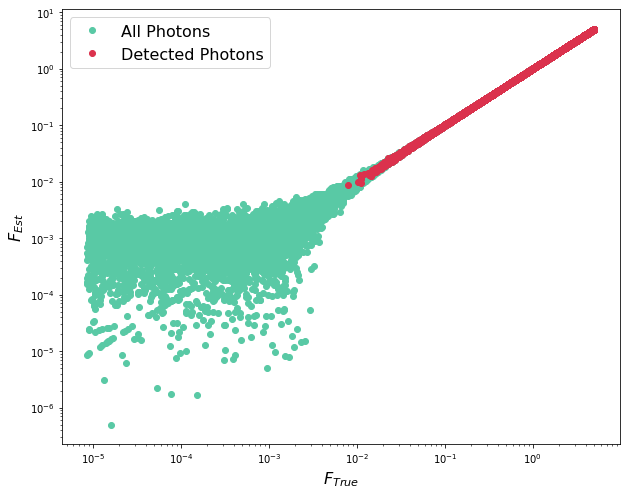

In [53]:
plt.figure(figsize=(10,8))
plt.loglog(true_flux, est_flux, 'o', color='#59C9A5', label='All Photons');
plt.loglog(detected_true_flux, detected_est_flux, 'o', color='#DB324D', label='Detected Photons');
plt.xlabel(r"$F_{True}$",fontsize=16)
plt.ylabel(r"$F_{Est}$", fontsize=16)
plt.legend(fontsize=16);


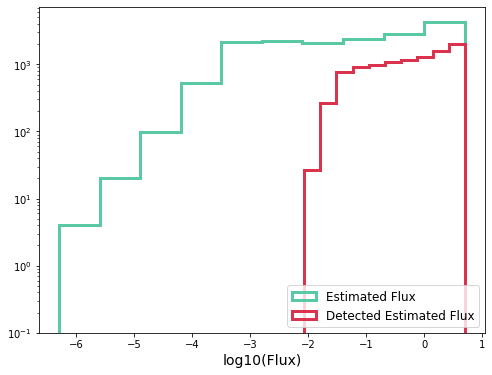

In [108]:
plt.figure(figsize=(8,6))
plt.hist(np.log10(est_flux), log=True, histtype='step', lw=3, color='#59C9A5', label='Estimated Flux');
plt.hist(np.log10(detected_est_flux), log=True, histtype='step', lw=3, color='#DB324D', label='Detected Estimated Flux');
plt.xlabel("log10(Flux)",fontsize=14)
plt.legend(fontsize=12, loc='lower right');

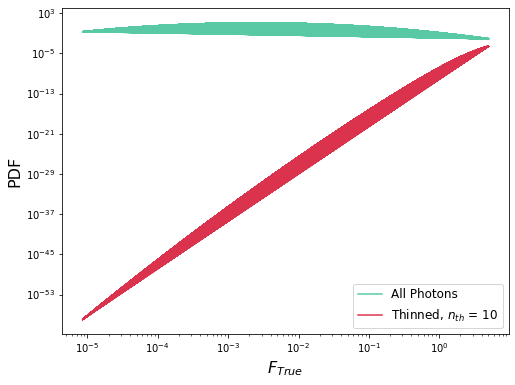

In [105]:
plt.figure(figsize=(8,6))
true_flux = np.array(true_flux)
plt.loglog(true_flux, eps*g(alpha, beta, true_flux), color='#59C9A5',label=r"All Photons");
plt.loglog(true_flux, eps*gammainc(nth/eps, true_flux)*g(alpha, beta, true_flux), color='#DB324D', label=r"Thinned, $n_{th}$ = %i"%nth);
plt.xlabel("$F_{True}$",fontsize=16)
plt.ylabel("PDF",fontsize=16)
plt.legend(fontsize=12, loc='lower right');

Interesting! So we sampled from the pdf, and when it's thinned (like the pdf conditioned on the data), we see that our posterior distribution cut off the lower end of the distribution because we have a much lower likelihood of detecting those dim photons.

<hr>

<font color='blue'>

#### Q9. Draw the PGM for the forward model you just simulated.

</font>

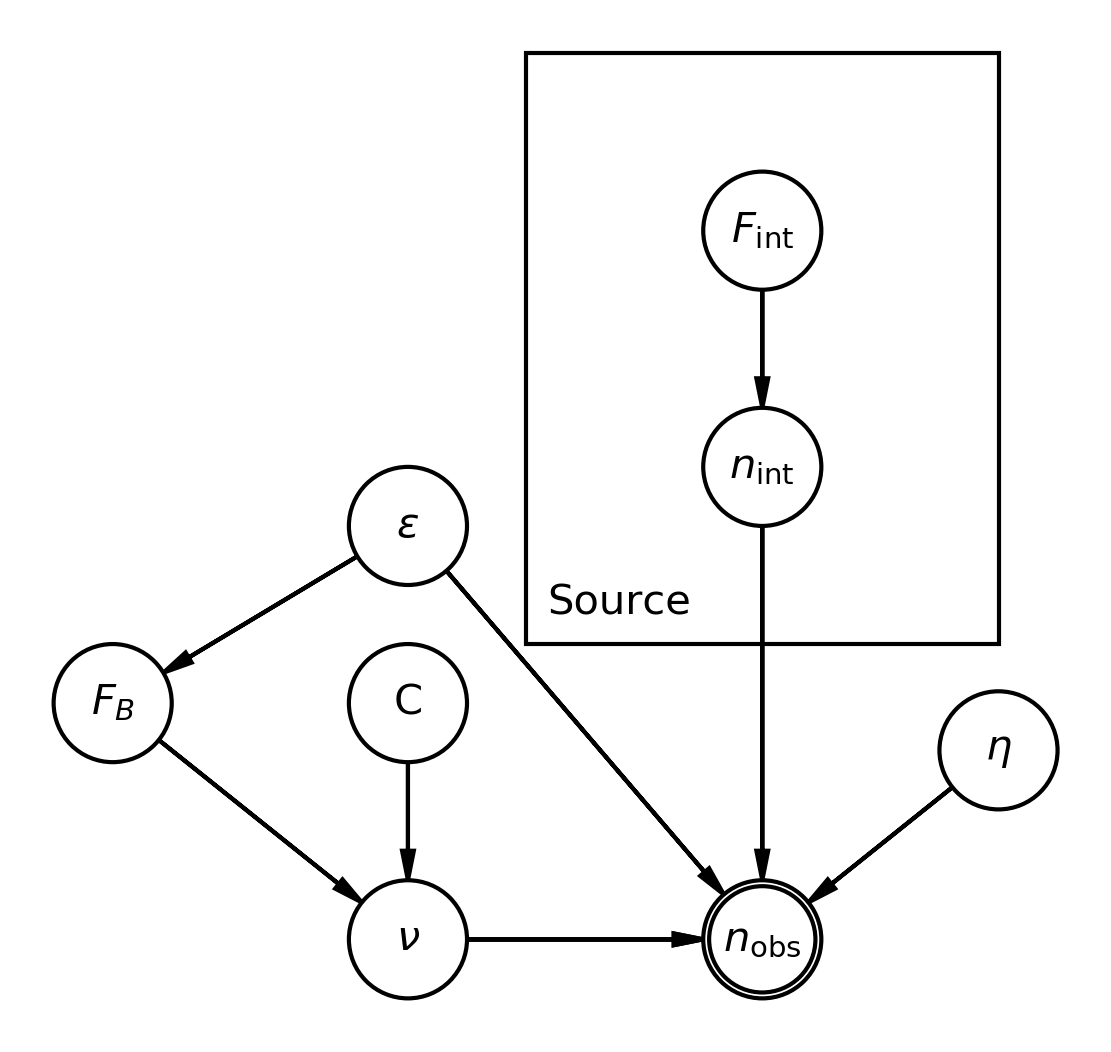

In [202]:
import daft

pgm = daft.PGM(observed_style="inner", dpi=300)
pgm.add_node("nu", r'$ \nu$', x=0.5, y=-2)
pgm.add_node("epsilon", r'$\epsilon$', x=0.5, y=-0.25)
pgm.add_node('nint', r'$n_{\mathrm{int}}$', x=2, y=0)
pgm.add_node('nobs', r'$n_{\mathrm{obs}}$', x=2, y=-2, observed=True)
pgm.add_node("F", r'$F_{\mathrm{int}}$', x=2, y=1)
pgm.add_node("C", r'C', x=0.5, y=-1)
pgm.add_node("B", r'$F_B$', x=-0.75, y=-1)
pgm.add_node("eta", r'$\eta$', x=3, y=-1.2)
pgm.add_edge("nu", "nobs")
pgm.add_edge("epsilon", "B")
pgm.add_edge("epsilon", "nobs")
pgm.add_edge('C',"nu")
pgm.add_edge("B", "nu")
pgm.add_edge("nu", "nobs")
pgm.add_edge("nint", "nobs")
pgm.add_edge("eta", "nobs")
pgm.add_edge("F", "nint" )
pgm.add_plate([1, -.75, 2, 2.5], "Source")
pgm.render();